In [1]:
import pandas as pd

# 加载数据集
train_data_path = './datasets/CTG/train.csv'
test_data_path = './datasets/CTG/test.csv'
predict_data_path = './datasets/CTG/predict.csv'

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
predict_df = pd.read_csv(predict_data_path)

# 显示每个数据集的前几行
train_df.head(), test_df.head(), predict_df.head()


(   number  baseline value  accelerations  fetal_movement  \
 0       1             135          0.006           0.000   
 1       2             141          0.000           0.007   
 2       3             133          0.000           0.000   
 3       4             112          0.000           0.000   
 4       5             143          0.008           0.000   
 
    uterine_contractions  light_decelerations  severe_decelerations  \
 0                 0.006                0.005                   0.0   
 1                 0.000                0.000                   0.0   
 2                 0.001                0.008                   0.0   
 3                 0.006                0.000                   0.0   
 4                 0.002                0.000                   0.0   
 
    prolongued_decelerations  abnormal_short_term_variability  \
 0                       0.0                               27   
 1                       0.0                               71   
 2       

1. 训练数据 (train.csv):

- 包含1767条记录

- 每条记录包含21个特征，包括 baseline value, accelerations, fetal movement 等

- 最后一列"fetal_health"作为分类标签, "1"为正常, "2"为疑似, "3"为病理性的

2. 测试数据 (test.csv):

- 包含280条记录

- 和训练数据类似除了没有"fetal_health"列

3. 预测数据 (predict.csv):

- 输出的预测结果保存在这个文件中

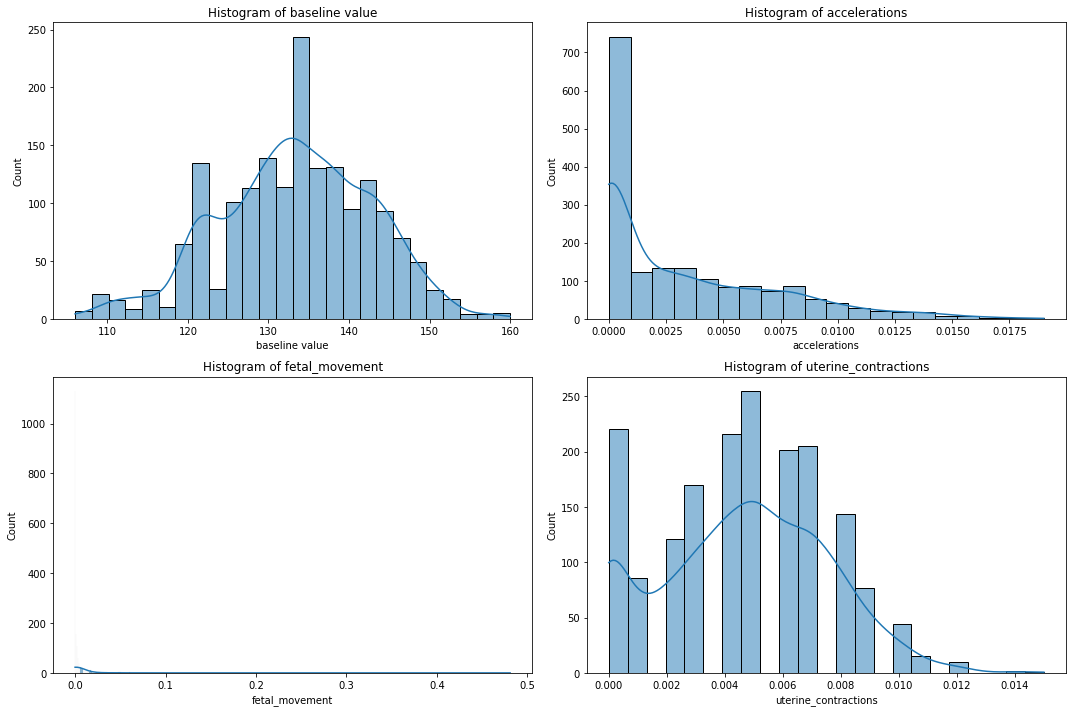

(number                                                    0
 baseline value                                            0
 accelerations                                             0
 fetal_movement                                            0
 uterine_contractions                                      0
 light_decelerations                                       0
 severe_decelerations                                      0
 prolongued_decelerations                                  0
 abnormal_short_term_variability                           0
 mean_value_of_short_term_variability                      0
 percentage_of_time_with_abnormal_long_term_variability    0
 mean_value_of_long_term_variability                       0
 histogram_width                                           0
 histogram_min                                             0
 histogram_max                                             0
 histogram_number_of_peaks                                 0
 histogram_number_of_zer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 检查训练数据中的缺失值
missing_values = train_df.isnull().sum()

# 用于了解分布和潜在异常的数据摘要
data_summary = train_df.describe()

# 可视化：一些选定特征的直方图
selected_features = ['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_df[feature], kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

missing_values, data_summary



## 数据理解和清理

1. 缺失值：

训练数据中没有缺失值，这非常适合模型训练。

2. 数据总结：

描述性统计显示不同特征的一系列值。 例如，“baseline value”的范围为 106 到 160，“accelerations”的范围为 0.0 到 0.019。

我们的目标变量“fetal_health”列的值为 1（正常）、2（可疑）和 3（病理性的）。

3. 可视化：

一些选定特征('baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions')的直方图显示了它们的分布。 这可以帮助识别模式和异常情况。

In [4]:
from sklearn.feature_selection import SelectKBest, f_classif

# 使用 ANOVA F 检验进行特征选择
X = train_df.drop(['fetal_health', 'number'], axis=1)  # 排除目标变量和“number”列
y = train_df['fetal_health']

# 应用 SelectKBest 类提取前 10 个最佳特征
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# 连接两个数据框以获得更好的可视化效果
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']  # 设置列名
top_features = featureScores.nlargest(10, 'Score')  # 前10个特征

top_features



,Feature,Score
6,prolongued_decelerations,527.613575
17,histogram_mean,322.420637
9,percentage_of_time_with_abnormal_long_term_var...,298.443214
16,histogram_mode,294.624473
7,abnormal_short_term_variability,273.882923
18,histogram_median,263.091141
19,histogram_variance,169.537982
1,accelerations,159.188915
8,mean_value_of_short_term_variability,148.798303
0,baseline value,122.033085


## 特征提取和选择

使用ANOVA F检验进行特征选择，与胎儿健康分类相关性最高的前10个特征是：

1. Prolongued Decelerations
2. Histogram Mean
3. Percentage of Time with Abnormal Long Term Variability
4. Histogram Mode
5. Abnormal Short Term Variability
6. Histogram Median
7. Histogram Variance
8. Accelerations
9. Mean Value of Short Term Variability
10. Baseline Value

这些特征显示出最高的分数，表明它们与胎儿健康的分类密切相关。我们将使用这些特征进行模型训练。

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 选择前 10 个特征进行模型训练
top_features_list = top_features['Feature'].tolist()
X_selected = X[top_features_list]

# 将数据分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 初始化模型
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
svm_model = SVC(random_state=42)

# 迭代模型列表
models = [rf_model, gb_model, svm_model]
model_names = ['Random Forest', 'Gradient Boosting', 'SVM']

# 训练和评估每个模型
model_performance = {}

for model, name in zip(models, model_names):
    # 训练
    model.fit(X_train, y_train)
    
    # 在验证集上预测
    val_predictions = model.predict(X_val)
    
    # 计算准确率
    accuracy = accuracy_score(y_val, val_predictions)
    model_performance[name] = accuracy

model_performance



{'Random Forest': 0.963276836158192,
 'Gradient Boosting': 0.9576271186440678,
 'SVM': 0.8700564971751412}

## 模型构建和训练结果

训练后的模型及其在验证集上的准确性如下：

1. 随机森林：准确率约为 96.33%
2. 梯度提升：准确度约为 95.76%
3. SVM（支持向量机）：准确度约为 87.01%

随机森林分类器在三个模型中显示出最高的准确度，使其成为此分类任务的不错选择。

In [7]:
# 准备测试集
X_test = test_df[top_features_list]

# 使用随机森林预测
test_predictions = rf_model.predict(X_test)

# 保存预测结果
predict_df['fetal_health'] = test_predictions

# 输出到CSV文件
predicted_file_path = './datasets/CTG/predicted_fetal_health.csv'
predict_df.to_csv(predicted_file_path, index=False)

predicted_file_path



'./CTG/predicted_fetal_health.csv'